In [1]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import yaml
import os
import matplotlib.pyplot as plt

from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.data import DataStore
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.modeling.models import (
    FoVBackgroundModel,
    Models,
)
from gammapy.modeling import Fit
from gammapy.datasets import MapDataset
from gammapy.irf import Background3D

import warnings
warnings.filterwarnings('ignore')

In [2]:
muoneff_flag= True
edisp = False

In [3]:
source_catalog = "Crab Nebula"
source = 'Crab'
pos = SkyCoord(83.6333313*u.deg, 22.01444435*u.deg, frame='icrs')
mask_sources = [[pos.ra.deg, pos.dec.deg, 0.4]] # given as a list, position and size

'''source_catalog = "NGC 253"
source = 'NGC253'
pos = SkyCoord(11.8875*u.deg, -25.2883*u.deg, frame='icrs')
mask_sources = [[pos.ra.deg, pos.dec.deg, 0.4]] # given as a list, position and size'''

'source_catalog = "NGC 253"\nsource = \'NGC253\'\npos = SkyCoord(11.8875*u.deg, -25.2883*u.deg, frame=\'icrs\')\nmask_sources = [[pos.ra.deg, pos.dec.deg, 0.4]] # given as a list, position and size'

In [4]:
hesseras = ['hess1', 'hess2']
if os.path.isdir(source)==False:
    os.system(f'mkdir {source}')

In [5]:
# loading general parameters
with open("../general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
conf=cfg['conf']
repo_path=cfg['repo_path']
N_ebins = cfg['N_ebins']
zen_bins = cfg['zen_bins']

muoneff_path = cfg['muoneff_path']
model_str = cfg['model_str']
energy_bins = np.logspace(-1, 2, N_ebins+1)

In [6]:
axis = MapAxis.from_edges(energy_bins, unit="TeV", name="energy", interp="log")
binsz=cfg['binsz']*u.deg
maker = MapDatasetMaker()
if edisp:
    maker_safe_mask = SafeMaskMaker(methods=['offset-max', 'bkg-peak', 'edisp-bias'], offset_max=cfg['offset_cut']*u.deg) 
else:
    maker_safe_mask = SafeMaskMaker(methods=['offset-max'], offset_max=cfg['offset_cut']*u.deg)
geom = WcsGeom.create(skydir=pos, binsz=binsz, width=12, frame="icrs", axes=[axis])
stacked = MapDataset.create(geom=geom)

In [7]:
final_runlist= []
for hessera in hesseras:
    basedir = f'$FITS_PROD/{hessera}/std_{conf}_fullEnclosure'
    ds = DataStore.from_dir(basedir, f'hdu-index-bg-latest-fov-radec.fits.gz', f'obs-index-bg-latest-fov-radec.fits.gz')
    obs_table = ds.obs_table

    # run selection
    mask_source = obs_table['OBJECT'] == source_catalog
    mask_tel = obs_table['N_TELS'] == cfg['mask_ntels']
    mask_zenpnt = obs_table['ZEN_PNT'] < cfg['mask_zenpnt']
    mask_eventcount = obs_table['EVENT_COUNT'] > cfg['mask_eventcount']
    mask_ontime = obs_table['ONTIME'] > cfg['mask_ontime']
    mask_final = mask_source & mask_tel & mask_zenpnt & mask_eventcount & mask_ontime 
    runlist = np.asarray(obs_table['OBS_ID'][mask_final])

    # preparing the dataset
    observations = ds.get_observations(runlist)

    for obs in observations:
        if muoneff_flag:
            muoneff_path = f'{cfg["muoneff_path"]}/{hessera}/hess1_hess2/v01c_kaori_mueff'
            if obs.obs_info['MUONEFF'] > 0.085:
                model_CD = 'B'
            elif obs.obs_info['MUONEFF'] >= 0.075:
                model_CD = 'D'
            else:
                model_CD = 'C'

            if obs.obs_id >= 100000:
                run_number= f'{obs.obs_id}'
            else:
                run_number= f'0{obs.obs_id}'
            filename = f'{muoneff_path}_{model_CD}/hess_bkg_3d_v01c_kaori_mueff_{model_CD}_norebin_fov_radec_{run_number}.fits.gz'
            obs.bkg = Background3D.read(filename, hdu='BACKGROUND')

        dataset = stacked.cutout(obs.pointing_radec, width=5)
        dataset = maker.run(dataset, obs)
                
        if muoneff_flag:        
            # this is to set bkg to 0 when it has unreasonable values in the highest energies
            spectrum = np.sum((dataset.background).data, axis=(1,2))
            for i in range(1, 5):
                if spectrum[-1*i] > spectrum[-1*(i+1)]:
                    dataset.background.data[-1*i] = 0

            # making mask_safe. Selecting like this the safe range starts from the bkgpeak from the bkg model construction
            # the reason of doing like this: when using maker_safe_mask('bkg-peak') there was a different values when using spatial
            # bin size 0.08 and 0.02. Probably a small issue within gammapy. To avoid it, calculate the energy threshold based on bkg peak
            # from the model itself and then apply it into the chosen axis for analysis. 
            dataset = maker_safe_mask.run(dataset, obs)
            idx_bkgpeak = np.argmax(np.sum(obs.bkg.data, axis=(1,2)))
            idx_bkgpeak_new = np.sum(axis.edges < obs.bkg.axes['energy'].edges[idx_bkgpeak])
            dataset.mask_safe.data[:idx_bkgpeak_new] = 0
        else:
            dataset = maker_safe_mask.run(dataset, obs)

        # create here mask_fit
        dataset.mask_fit = Map.from_geom(geom=dataset.counts.geom, data=np.ones_like(dataset.counts.data).astype(bool))   
        
        for mask_pos in mask_sources:
            dataset.mask_fit &= ~dataset.counts.geom.region_mask(f"icrs;circle({mask_pos[0]}, {mask_pos[1]}, {mask_pos[2]})")

        bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
        dataset.models = Models([bkg_model])
        dataset.background_model.spectral_model.tilt.frozen = False

        Fit().run(datasets=[dataset])
        
        if dataset.background_model.spectral_model.norm.value > 0:
            final_runlist.append(obs.obs_id)
            dataset.background.data[~dataset.mask_safe.data] = 0.0
            stacked.stack(dataset) 
        else:
            info_file.write(f'\nrun: with problem={obs.obs_id}\n')

No HDU found matching: OBS_ID = 18386, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 18406, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 18415, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 18478, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 18480, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 18526, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 18561, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 18564, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 18598, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 18870, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 18871, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 18872, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 18873, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found

In [8]:
obsid_list = np.asarray(final_runlist)
stacked.write(f'{source}/stacked.fits', overwrite=True)
np.savetxt(f'{source}/runlist.txt', obsid_list)

## checking the stacked dataset

In [9]:
print(f'there are {len(final_runlist)} runs in the stacked dataset')

there are 204 runs in the stacked dataset


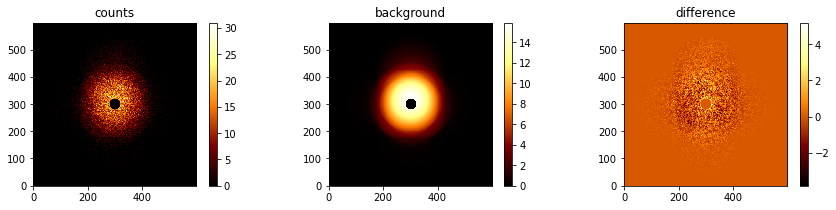

In [10]:
for mask_pos in mask_sources:
    stacked.mask_safe &= ~stacked.counts.geom.region_mask(f"icrs;circle({mask_pos[0]}, {mask_pos[1]}, {mask_pos[2]})")

fig, ax = plt.subplots(1,3, figsize=(15, 3))
(stacked.counts*stacked.mask_safe).sum_over_axes().plot(add_cbar=True, ax=ax[0])
ax[0].set_title('counts')
(stacked.background*stacked.mask_safe).sum_over_axes().plot(add_cbar=True, ax=ax[1])
ax[1].set_title('background')
(stacked.residuals()*stacked.mask_safe).sum_over_axes().smooth(1).plot(add_cbar=True, ax=ax[2])
ax[2].set_title('difference')
plt.show()

In [11]:
from gammapy.estimators import ExcessMapEstimator

estimator = ExcessMapEstimator(
    correlation_radius="0.07 deg",
    selection_optional=[],
    energy_edges=[0.1, 100] * u.TeV,
)
result = estimator.run(stacked)

Position <SkyCoord (ICRS): (ra, dec) in deg
    (83.6333313, 22.01444435)> is outside valid IRF map range, using nearest IRF defined within


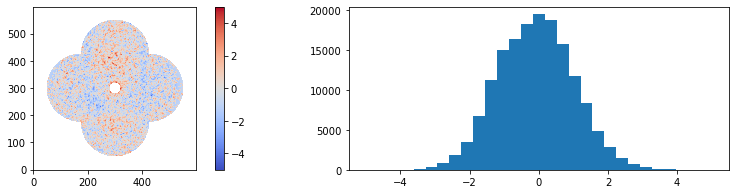

In [12]:
fig, ax = plt.subplots(1,2, figsize=(15, 3))

result["sqrt_ts"].plot(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ax=ax[0]);
ax[1].hist(result["sqrt_ts"].data.ravel(), bins=np.linspace(-5,5,30));

Text(0, 0.5, 'counts')

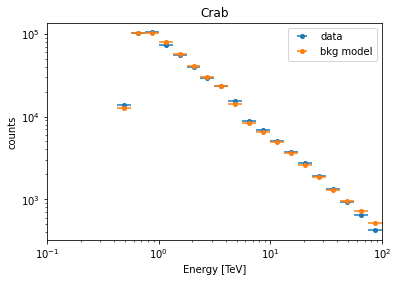

In [13]:
(stacked.counts*stacked.mask_safe).get_spectrum().plot(label='data')
(stacked.background*stacked.mask_safe).get_spectrum().plot(label='bkg model')
plt.legend()
plt.title(source)
plt.ylabel('counts')